In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, regexp_replace, trim, col, lower
from pyspark.sql.functions import sum as _sum
from pyspark.sql import functions as F, Window
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import re

The key data type used in PySpark is the Spark dataframe.\
This object can be thought of as a table distributed across a cluster and has functionality that is similar to dataframes in Pandas.\
Creating the spark dataframe

In [2]:
spark = SparkSession.builder.appName('Practice').getOrCreate()

In [3]:
df_pyspark = spark.read.csv('Data/test_data.tsv', sep=r'\t', header=True)# change file path

In [4]:
### Check the schema and type
#df_pyspark.printSchema()
#df_pyspark.show()
type(df_pyspark)

pyspark.sql.dataframe.DataFrame

#Remove All Punctuation Marks as per the requirement
#e.g. 'coffee_large', 'coffee-large' will be coffee large

In [5]:
def removePunctuation(column):
     return trim(lower(regexp_replace(column,'[^\sa-zA-Z0-9]', ' '))).alias('stopped')

In [6]:
df_pyspark = df_pyspark.withColumn('product_names',removePunctuation('product_name'))

In [7]:
#df_pyspark.show()

# The transactions belonging to two stores should fit in the memory. The transaction data contain refunds (unit < 0) that must be filtered out. Calculate relative sales

In [8]:
df_pyspark =  df_pyspark.filter(((df_pyspark.store_id == 1) | (df_pyspark.store_id == 3)) & (df_pyspark.price >=0))
df_pyspark = df_pyspark.select(col("product_names"),col("store_id"),col("units"))
df_pyspark = df_pyspark.groupBy("store_id", "product_names").agg(_sum('units').alias('sale_count'))
df_pyspark_test = df_pyspark.withColumn('relative_sales',
    F.col('sale_count') / 
    F.sum('sale_count').over(Window.partitionBy('store_id'))
)


In [9]:
#display(df_pyspark_test)

In [10]:
#df_pyspark_test.show()

# Visualization

In [11]:
pdf1=df_pyspark_test.toPandas()

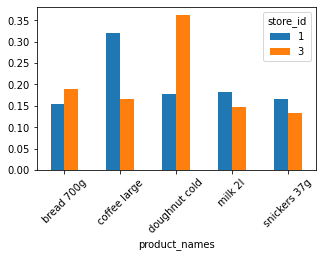

In [13]:
####################################
#TODO: plot bar here
pivot_df = pdf1.pivot(index='product_names', columns='store_id',
                                 values='relative_sales')
# plot
pivot_df.plot(kind='bar', figsize=(5, 3), rot=0)
plt.xticks(rotation=45)
#plt.tight_layout()
plt.show()